# Quasar spectra using qso.make_templates
The goal of this notebook is to generate a set of quasar spectra simulations, that are then analized with redrock to classify and get the redshift. 

We assume that desi code is installed as described in :
https://desi.lbl.gov/trac/wiki/Pipeline/GettingStarted/Laptop/JuneMeeting
And this uses the Master Branch

In [1]:
%pylab inline
import os
import matplotlib.pyplot as plt



import numpy as np
from astropy.io import fits
from astropy.table import Table
import desispec.io
import desisim.io


Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.signal import medfilt
def plotspec(spectra, i, truewave=None, trueflux=None, nfilter=11):
    plt.plot(spectra.wave['b'], medfilt(spectra.flux['b'][i], nfilter), 'b', alpha=0.5)
    plt.plot(spectra.wave['r'], medfilt(spectra.flux['r'][i], nfilter), 'r', alpha=0.5)
    plt.plot(spectra.wave['z'], medfilt(spectra.flux['z'][i], nfilter), 'k', alpha=0.5)
    if truewave is not None and trueflux is not None:
        plt.plot(truewave, trueflux[i], 'k-')

    plt.axhline(0, color='k', alpha=0.2)
        
    ymin = ymax = 0.0
    for x in ['b', 'r', 'z']:
        tmpmin, tmpmax = np.percentile(spectra.flux['r'][i], [1, 99])
        ymin = min(tmpmin, ymin)
        ymax = max(tmpmax, ymax)
        
    plt.ylim(ymin, ymax)
    plt.ylabel('flux [1e-17 erg/s/cm2/A]')
    plt.xlabel('wavelength [A]')
    plt.xlim(3000, 6300)

## Environment variables and data

We will specify the enviroment variables, specially where to find the DESI spectra templates, and where do we want to save the simulated spectra. Then check enviroment variables. I assumes the desi enviroment is already set. 

In [3]:
def check_env():
    for env in ('DESIMODEL', 'DESI_ROOT', 'DESI_SPECTRO_SIM', 'DESI_SPECTRO_DATA', 
            'DESI_SPECTRO_REDUX', 'SPECPROD', 'PIXPROD'):
        if env in os.environ:
            print('{} environment set to {}'.format(env, os.getenv(env)))
        else:
            print('Required environment variable {} not set!'.format(env))
            
check_env()

%set_env SPECPROD=alxogm/Lya_test
%set_env PIXPROD=alxogm/Lya_test
rawdata_dir = desisim.io.simdir()
%set_env DESI_SPECTRO_DATA=$rawdata_dir

print('Simulated raw data will be written to {}'.format(desisim.io.simdir()))
print('Pipeline will read raw data from {}'.format(desispec.io.rawdata_root()))
print('    (without knowing that it was simulated)')
print('Pipeline will write processed data to {}'.format(desispec.io.specprod_root()))

DESIMODEL environment set to /global/common/software/desi/cori/desiconda/current/code/desimodel/master
DESI_ROOT environment set to /global/project/projectdirs/desi
DESI_SPECTRO_SIM environment set to /global/project/projectdirs/desi/spectro/sim
DESI_SPECTRO_DATA environment set to /global/project/projectdirs/desi/spectro/data
DESI_SPECTRO_REDUX environment set to /global/project/projectdirs/desi/spectro/redux
SPECPROD environment set to alxogm
PIXPROD environment set to alxogm
env: SPECPROD=alxogm/Lya_test
env: PIXPROD=alxogm/Lya_test
env: DESI_SPECTRO_DATA=/global/project/projectdirs/desi/spectro/sim/alxogm/Lya_test/
Simulated raw data will be written to /global/project/projectdirs/desi/spectro/sim/alxogm/Lya_test/
Pipeline will read raw data from /global/project/projectdirs/desi/spectro/sim/alxogm/Lya_test/
    (without knowing that it was simulated)
Pipeline will write processed data to /global/project/projectdirs/desi/spectro/redux/alxogm/Lya_test


In [4]:
from desisim.templates import QSO

seed = 125
nmodel = 100

In [5]:
qso = QSO(minwave=3000, maxwave=5e4)

In [6]:
from desisim import lya_spectra 

In [7]:
lya_spectra?

In [8]:
from desisim.templates import QSO

seed = 125
nmodel =1

In [16]:
qso = QSO(minwave=3000, maxwave=5e4)

flux_, wave_, meta_ = qso.make_templates(nmodel=nmodel, zrange=(2.0, 4.0), seed=seed, 
                                      nocolorcuts=True, lyaforest=True)

In [17]:
meta_['REDSHIFT']

3.96394831028


In [18]:
from desisim.dla import insert_dlas
if np.min(wave_/1215.67 - 1) < meta_['REDSHIFT']: # Any forest?
    dlas, dla_model = insert_dlas(wave_, meta_['REDSHIFT'], seed=seed)
    ndla = len(dlas)
    if ndla > 0:
        flux_ *= dla_model
        # Meta
        dla_z += [idla['z'] for idla in dlas]
        dla_NHI += [idla['N'] for idla in dlas]
        dla_id += [indx]*ndla

In [19]:
simdir = rawdata_dir+'desi/simspec'
infile = simdir + '/qso-adddla-spectra_.fits'
hdr = fits.Header()
hdr['EXTNAME'] = 'WAVELENGTH'
hdr['BUNIT'] = 'Angstrom'
fits.writeto(infile, wave_, header=hdr, clobber=True)
hdr['EXTNAME'] = 'FLUX'
hdr['BUNIT'] = '10^-17 ergs/s/cm2/A'
fits.append(infile, flux_, header=hdr)
hdr['EXTNAME']='META'
fits.append(infile, np.asarray(meta_), header=hdr)

In [20]:
specoutfile_dla='/global/project/projectdirs/desi/spectro/sim/alxogm/Lya_test/desi/simspec/qso-dla-spectra.fits'
cmd = 'quickspectra -i {} -o {}'.format(infile, specoutfile_dla)
print(cmd)
!$cmd

quickspectra -i /global/project/projectdirs/desi/spectro/sim/alxogm/Lya_test/desi/simspec/qso-adddla-spectra_.fits -o /global/project/projectdirs/desi/spectro/sim/alxogm/Lya_test/desi/simspec/qso-dla-spectra.fits
INFO:quickspectra.py:301:main: Reading an input FITS file
INFO:quickspectra.py:336:main: input flux shape = (1, 235001)
INFO:quickspectra.py:59:sim_spectra: Starting simulation of 1 spectra
DEBUG:simexp.py:408:simulate_spectra: loading specsim desi config desi
DEBUG:simexp.py:412:simulate_spectra: creating specsim desi simulator
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)
INFO:simexp.py:434:simulate_spectra: MJD not in obscondition

In [21]:
spectra_dla = desispec.io.read_spectra(specoutfile_dla)

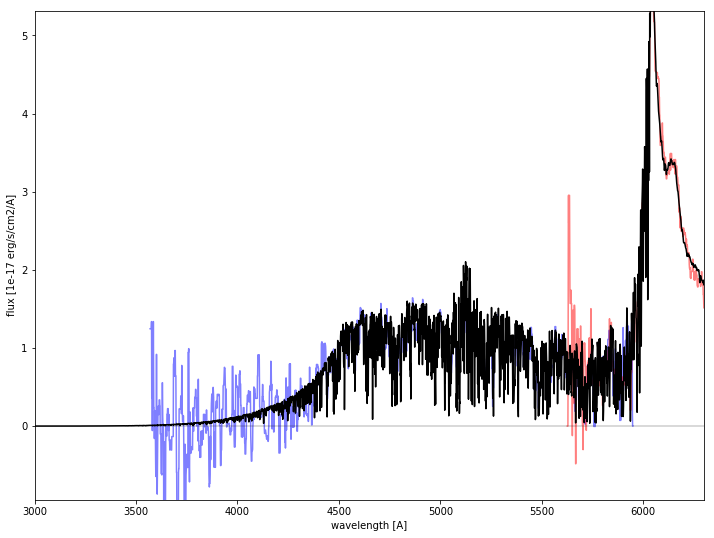

In [22]:
plt.figure(figsize=(12,9))
for i in range(1):
    plotspec(spectra_dla, i, wave_, flux_)